# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

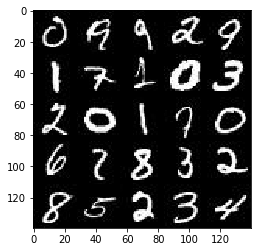

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

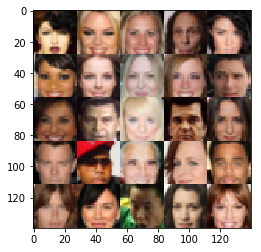

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32)

    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #image 28*28*3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, 2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)     
        
        

    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, training=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not training):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512, activation=None)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, alpha=alpha, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1-smooth)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

#     # Optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

#     return d_train_opt, g_train_opt

    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    return d_train, g_train

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, example_z):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    #z_dim = input_z.get_shape().as_list()[-1]
    
    #example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])  



    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #x = tf.Variable(0)
    sample_z = np.random.uniform(-1, 1, size=(25, z_dim))

    samples, losses = [], []
    steps = 0
    
    # Input parameters
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # d_loss and g_loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    # Optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #saver.restore(sess, './checkpoints/generator.ckpt')
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    
                # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})


                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode, sample_z)
                    
        saver = tf.train.Saver()   
        saver.save(sess, './checkpoints/generator.ckpt')


    
    return losses, samples


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 1.6281
Epoch 1/2... Discriminator Loss: 1.8906... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 1.6126... Generator Loss: 1.5258
Epoch 1/2... Discriminator Loss: 1.5507... Generator Loss: 1.2328
Epoch 1/2... Discriminator Loss: 1.5595... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.5744
Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 0.5269
Epoch 1/2... Discriminator Loss: 1.5719... Generator Loss: 0.5186
Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.5242


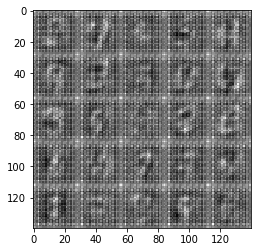

Epoch 1/2... Discriminator Loss: 1.2596... Generator Loss: 0.7030
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.5952
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 1.2901
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 1.5997


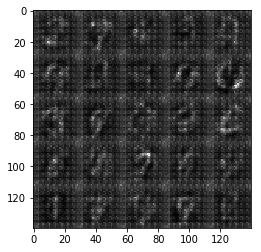

Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 0.9851
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.0901
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.3103
Epoch 1/2... Discriminator Loss: 1.0439... Generator Loss: 1.4661
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.6205


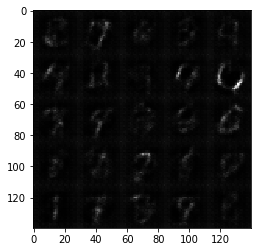

Epoch 1/2... Discriminator Loss: 1.0959... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 0.9649... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 1.0161
Epoch 1/2... Discriminator Loss: 1.4241... Generator Loss: 1.9535
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 1.5820
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 1.5633
Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 1.0284
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 1.3758
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.5294
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.5996


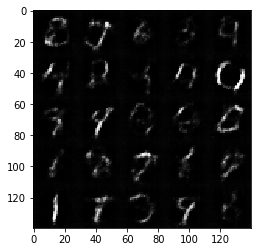

Epoch 1/2... Discriminator Loss: 1.1897... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.6347... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 0.7400
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.5552
Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 0.6502
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.5733... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 0.9917
Epoch 2/2... Discriminator Loss: 1.6334... Generator Loss: 2.1935


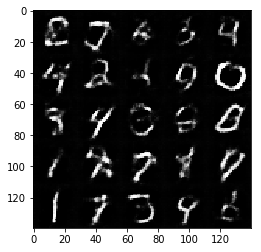

Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.7561
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.9768
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.2768
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 1.0853
Epoch 2/2... Discriminator Loss: 1.2882... Generator Loss: 0.5847
Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 0.5850
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 1.0999... Generator Loss: 0.7540


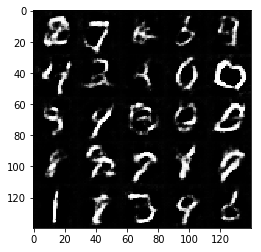

Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 1.3167
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 1.7880
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.8021
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 2.4772... Generator Loss: 2.2350
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.8383
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 1.1828
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 1.2120


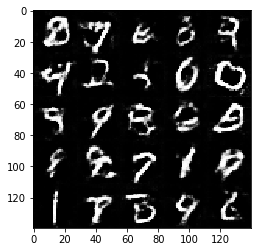

Epoch 2/2... Discriminator Loss: 1.1745... Generator Loss: 1.0144
Epoch 2/2... Discriminator Loss: 1.0395... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 1.7644... Generator Loss: 2.3642
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 0.9761
Epoch 2/2... Discriminator Loss: 1.2415... Generator Loss: 0.6268
Epoch 2/2... Discriminator Loss: 1.1890... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.7483... Generator Loss: 0.4364
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.7929
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.0057
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 1.1957


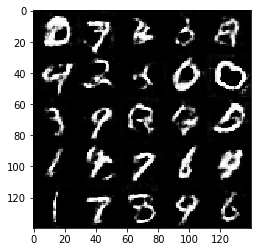

Epoch 2/2... Discriminator Loss: 1.3447... Generator Loss: 0.5607
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 1.1177
Epoch 2/2... Discriminator Loss: 2.5725... Generator Loss: 2.9577
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 0.6629
Epoch 2/2... Discriminator Loss: 1.0354... Generator Loss: 1.0711
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 1.6501
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 0.6873
Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 1.0589


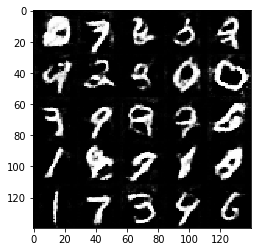

Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 1.1244
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.8010


In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 1.9844... Generator Loss: 0.5101
Epoch 1/3... Discriminator Loss: 1.1947... Generator Loss: 0.8848
Epoch 1/3... Discriminator Loss: 1.0405... Generator Loss: 0.9202
Epoch 1/3... Discriminator Loss: 0.7714... Generator Loss: 3.1184
Epoch 1/3... Discriminator Loss: 1.3874... Generator Loss: 0.8703
Epoch 1/3... Discriminator Loss: 1.0597... Generator Loss: 1.2793
Epoch 1/3... Discriminator Loss: 1.2068... Generator Loss: 1.6471
Epoch 1/3... Discriminator Loss: 1.0476... Generator Loss: 2.0294
Epoch 1/3... Discriminator Loss: 1.0094... Generator Loss: 1.0128
Epoch 1/3... Discriminator Loss: 1.1144... Generator Loss: 0.9676


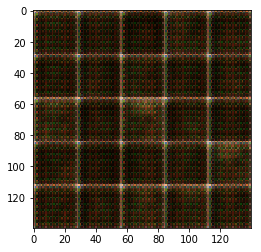

Epoch 1/3... Discriminator Loss: 1.0623... Generator Loss: 1.3067
Epoch 1/3... Discriminator Loss: 1.4337... Generator Loss: 0.6890
Epoch 1/3... Discriminator Loss: 1.0794... Generator Loss: 1.3032
Epoch 1/3... Discriminator Loss: 1.4005... Generator Loss: 0.6370
Epoch 1/3... Discriminator Loss: 1.2146... Generator Loss: 1.1189
Epoch 1/3... Discriminator Loss: 1.2710... Generator Loss: 0.8899
Epoch 1/3... Discriminator Loss: 1.3217... Generator Loss: 0.7367
Epoch 1/3... Discriminator Loss: 1.1691... Generator Loss: 1.3618
Epoch 1/3... Discriminator Loss: 1.7124... Generator Loss: 0.5413
Epoch 1/3... Discriminator Loss: 1.1838... Generator Loss: 1.1667


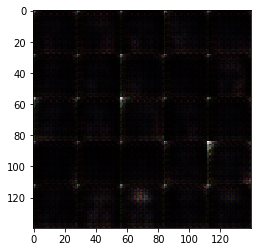

Epoch 1/3... Discriminator Loss: 1.3893... Generator Loss: 0.6189
Epoch 1/3... Discriminator Loss: 1.1281... Generator Loss: 1.0559
Epoch 1/3... Discriminator Loss: 1.0463... Generator Loss: 1.0495
Epoch 1/3... Discriminator Loss: 1.1315... Generator Loss: 0.8844
Epoch 1/3... Discriminator Loss: 1.5846... Generator Loss: 0.5643
Epoch 1/3... Discriminator Loss: 1.0675... Generator Loss: 1.4709
Epoch 1/3... Discriminator Loss: 1.5040... Generator Loss: 0.7128
Epoch 1/3... Discriminator Loss: 1.1546... Generator Loss: 1.2061
Epoch 1/3... Discriminator Loss: 1.5701... Generator Loss: 0.5916
Epoch 1/3... Discriminator Loss: 1.0201... Generator Loss: 1.0855


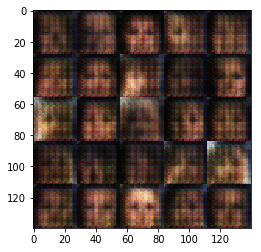

Epoch 1/3... Discriminator Loss: 1.4242... Generator Loss: 0.8116
Epoch 1/3... Discriminator Loss: 1.3528... Generator Loss: 0.7863
Epoch 1/3... Discriminator Loss: 1.4166... Generator Loss: 1.2098
Epoch 1/3... Discriminator Loss: 1.3801... Generator Loss: 0.8968
Epoch 1/3... Discriminator Loss: 1.3967... Generator Loss: 0.8420
Epoch 1/3... Discriminator Loss: 1.3872... Generator Loss: 0.7804
Epoch 1/3... Discriminator Loss: 1.2523... Generator Loss: 1.1299
Epoch 1/3... Discriminator Loss: 1.2708... Generator Loss: 0.8390
Epoch 1/3... Discriminator Loss: 1.5599... Generator Loss: 1.2843
Epoch 1/3... Discriminator Loss: 1.4309... Generator Loss: 0.6550


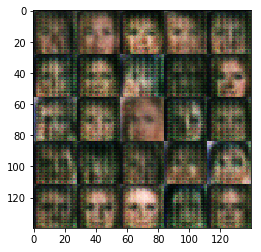

Epoch 1/3... Discriminator Loss: 1.2853... Generator Loss: 0.8192
Epoch 1/3... Discriminator Loss: 1.2085... Generator Loss: 1.0430
Epoch 1/3... Discriminator Loss: 1.2447... Generator Loss: 0.8403
Epoch 1/3... Discriminator Loss: 1.3334... Generator Loss: 0.9319
Epoch 1/3... Discriminator Loss: 1.5647... Generator Loss: 0.6294
Epoch 1/3... Discriminator Loss: 1.4007... Generator Loss: 0.7087
Epoch 1/3... Discriminator Loss: 1.1997... Generator Loss: 1.0015
Epoch 1/3... Discriminator Loss: 1.2840... Generator Loss: 0.8230
Epoch 1/3... Discriminator Loss: 1.3954... Generator Loss: 1.1384
Epoch 1/3... Discriminator Loss: 1.2501... Generator Loss: 1.3923


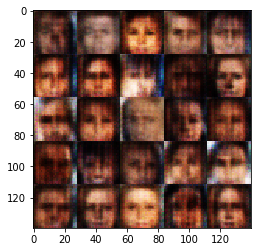

Epoch 1/3... Discriminator Loss: 1.4732... Generator Loss: 0.9445
Epoch 1/3... Discriminator Loss: 1.5015... Generator Loss: 0.7309
Epoch 1/3... Discriminator Loss: 1.4330... Generator Loss: 1.0421
Epoch 1/3... Discriminator Loss: 1.3071... Generator Loss: 0.8934
Epoch 1/3... Discriminator Loss: 1.4316... Generator Loss: 0.7822
Epoch 1/3... Discriminator Loss: 1.4308... Generator Loss: 0.7275
Epoch 1/3... Discriminator Loss: 1.4357... Generator Loss: 0.7214
Epoch 1/3... Discriminator Loss: 1.3855... Generator Loss: 0.7258
Epoch 1/3... Discriminator Loss: 1.4069... Generator Loss: 0.7262
Epoch 1/3... Discriminator Loss: 1.4421... Generator Loss: 1.0160


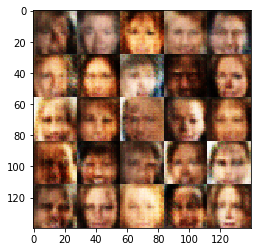

Epoch 1/3... Discriminator Loss: 1.1256... Generator Loss: 1.0250
Epoch 1/3... Discriminator Loss: 1.3636... Generator Loss: 0.9364
Epoch 1/3... Discriminator Loss: 1.3369... Generator Loss: 0.7819
Epoch 1/3... Discriminator Loss: 1.3104... Generator Loss: 0.8203
Epoch 1/3... Discriminator Loss: 1.3611... Generator Loss: 0.8243
Epoch 1/3... Discriminator Loss: 1.4030... Generator Loss: 0.7456
Epoch 1/3... Discriminator Loss: 1.3402... Generator Loss: 1.1664
Epoch 1/3... Discriminator Loss: 1.4373... Generator Loss: 0.6880
Epoch 1/3... Discriminator Loss: 1.4518... Generator Loss: 1.0562
Epoch 1/3... Discriminator Loss: 1.3024... Generator Loss: 1.0246


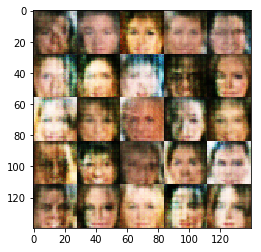

Epoch 1/3... Discriminator Loss: 1.3543... Generator Loss: 0.8537
Epoch 1/3... Discriminator Loss: 1.3886... Generator Loss: 0.8153
Epoch 1/3... Discriminator Loss: 1.2729... Generator Loss: 1.0038
Epoch 1/3... Discriminator Loss: 1.4297... Generator Loss: 0.6754
Epoch 1/3... Discriminator Loss: 1.3511... Generator Loss: 0.8533
Epoch 1/3... Discriminator Loss: 1.2108... Generator Loss: 0.9920
Epoch 1/3... Discriminator Loss: 1.2426... Generator Loss: 0.9516
Epoch 1/3... Discriminator Loss: 1.2220... Generator Loss: 0.9233
Epoch 1/3... Discriminator Loss: 1.2015... Generator Loss: 0.9091
Epoch 1/3... Discriminator Loss: 1.2517... Generator Loss: 1.0073


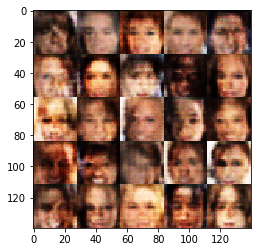

Epoch 1/3... Discriminator Loss: 1.3671... Generator Loss: 0.9433
Epoch 1/3... Discriminator Loss: 1.2300... Generator Loss: 0.9930
Epoch 1/3... Discriminator Loss: 1.2707... Generator Loss: 0.8638
Epoch 1/3... Discriminator Loss: 1.1881... Generator Loss: 0.8836
Epoch 1/3... Discriminator Loss: 1.2383... Generator Loss: 0.8076
Epoch 1/3... Discriminator Loss: 1.3349... Generator Loss: 0.9886
Epoch 1/3... Discriminator Loss: 1.2165... Generator Loss: 0.7823
Epoch 1/3... Discriminator Loss: 1.3297... Generator Loss: 0.8060
Epoch 1/3... Discriminator Loss: 1.2369... Generator Loss: 0.7872
Epoch 1/3... Discriminator Loss: 1.1867... Generator Loss: 0.7679


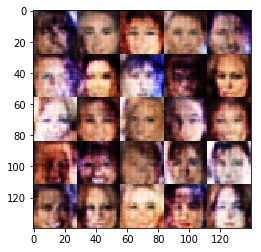

Epoch 1/3... Discriminator Loss: 1.0770... Generator Loss: 1.2448
Epoch 1/3... Discriminator Loss: 1.2997... Generator Loss: 1.5191
Epoch 1/3... Discriminator Loss: 1.3789... Generator Loss: 0.7388
Epoch 1/3... Discriminator Loss: 1.2085... Generator Loss: 0.7948
Epoch 1/3... Discriminator Loss: 1.3470... Generator Loss: 0.6146
Epoch 1/3... Discriminator Loss: 1.3147... Generator Loss: 0.7736
Epoch 1/3... Discriminator Loss: 1.4028... Generator Loss: 0.7348
Epoch 1/3... Discriminator Loss: 1.3482... Generator Loss: 0.8907
Epoch 1/3... Discriminator Loss: 1.1263... Generator Loss: 1.2156
Epoch 1/3... Discriminator Loss: 1.3799... Generator Loss: 1.1516


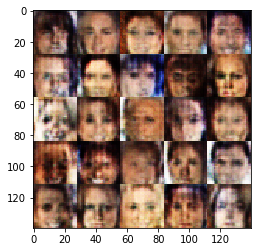

Epoch 1/3... Discriminator Loss: 1.0929... Generator Loss: 1.0750
Epoch 1/3... Discriminator Loss: 1.3947... Generator Loss: 0.8414
Epoch 1/3... Discriminator Loss: 1.3418... Generator Loss: 0.7346
Epoch 1/3... Discriminator Loss: 1.2599... Generator Loss: 0.9535
Epoch 1/3... Discriminator Loss: 1.3939... Generator Loss: 0.6518
Epoch 1/3... Discriminator Loss: 1.2642... Generator Loss: 0.7567
Epoch 1/3... Discriminator Loss: 1.1540... Generator Loss: 1.1712
Epoch 1/3... Discriminator Loss: 1.1825... Generator Loss: 0.8426
Epoch 1/3... Discriminator Loss: 1.0401... Generator Loss: 1.3928
Epoch 1/3... Discriminator Loss: 1.2496... Generator Loss: 0.6982


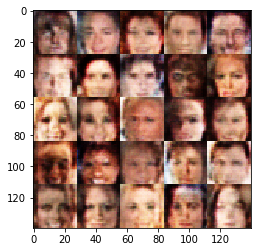

Epoch 1/3... Discriminator Loss: 1.1192... Generator Loss: 1.1207
Epoch 1/3... Discriminator Loss: 1.3869... Generator Loss: 0.7366
Epoch 1/3... Discriminator Loss: 1.3664... Generator Loss: 0.6976
Epoch 1/3... Discriminator Loss: 1.1900... Generator Loss: 0.7866
Epoch 1/3... Discriminator Loss: 1.0769... Generator Loss: 0.9193
Epoch 1/3... Discriminator Loss: 1.4908... Generator Loss: 1.0969
Epoch 1/3... Discriminator Loss: 1.4600... Generator Loss: 0.5982
Epoch 1/3... Discriminator Loss: 1.2562... Generator Loss: 0.7208
Epoch 1/3... Discriminator Loss: 1.2272... Generator Loss: 0.6869
Epoch 1/3... Discriminator Loss: 1.3598... Generator Loss: 1.0264


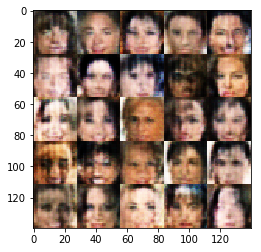

Epoch 1/3... Discriminator Loss: 1.2512... Generator Loss: 0.9079
Epoch 1/3... Discriminator Loss: 1.1713... Generator Loss: 0.8863
Epoch 1/3... Discriminator Loss: 1.2308... Generator Loss: 1.5730
Epoch 1/3... Discriminator Loss: 1.1943... Generator Loss: 0.9749
Epoch 1/3... Discriminator Loss: 1.0324... Generator Loss: 1.1535
Epoch 1/3... Discriminator Loss: 1.1896... Generator Loss: 0.9953
Epoch 1/3... Discriminator Loss: 1.2267... Generator Loss: 0.8830
Epoch 1/3... Discriminator Loss: 1.3280... Generator Loss: 0.7587
Epoch 1/3... Discriminator Loss: 1.3972... Generator Loss: 0.6494
Epoch 1/3... Discriminator Loss: 1.3250... Generator Loss: 0.6868


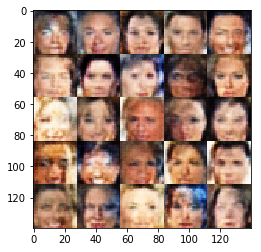

Epoch 1/3... Discriminator Loss: 1.5369... Generator Loss: 0.5341
Epoch 1/3... Discriminator Loss: 1.2806... Generator Loss: 0.9205
Epoch 1/3... Discriminator Loss: 1.0383... Generator Loss: 1.0740
Epoch 1/3... Discriminator Loss: 1.2246... Generator Loss: 0.7968
Epoch 1/3... Discriminator Loss: 1.2417... Generator Loss: 0.9732
Epoch 1/3... Discriminator Loss: 1.2885... Generator Loss: 0.7591
Epoch 1/3... Discriminator Loss: 1.3323... Generator Loss: 1.0053
Epoch 1/3... Discriminator Loss: 1.2462... Generator Loss: 1.2248
Epoch 1/3... Discriminator Loss: 1.4871... Generator Loss: 0.6009
Epoch 1/3... Discriminator Loss: 1.0760... Generator Loss: 1.0247


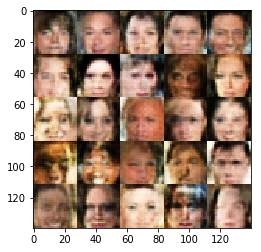

Epoch 1/3... Discriminator Loss: 1.2012... Generator Loss: 0.9885
Epoch 1/3... Discriminator Loss: 1.1863... Generator Loss: 0.8280
Epoch 1/3... Discriminator Loss: 1.3176... Generator Loss: 0.6822
Epoch 1/3... Discriminator Loss: 0.9399... Generator Loss: 1.2168
Epoch 1/3... Discriminator Loss: 1.3577... Generator Loss: 0.7383
Epoch 1/3... Discriminator Loss: 1.2565... Generator Loss: 0.9173
Epoch 1/3... Discriminator Loss: 1.2688... Generator Loss: 0.9423
Epoch 1/3... Discriminator Loss: 1.2464... Generator Loss: 1.2811
Epoch 1/3... Discriminator Loss: 1.2534... Generator Loss: 1.3883
Epoch 1/3... Discriminator Loss: 1.2840... Generator Loss: 0.7630


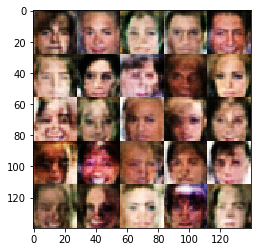

Epoch 1/3... Discriminator Loss: 1.1064... Generator Loss: 1.3348
Epoch 1/3... Discriminator Loss: 1.2658... Generator Loss: 0.8412
Epoch 1/3... Discriminator Loss: 1.2492... Generator Loss: 1.0162
Epoch 1/3... Discriminator Loss: 1.3204... Generator Loss: 0.8105
Epoch 1/3... Discriminator Loss: 1.3340... Generator Loss: 0.7755
Epoch 1/3... Discriminator Loss: 1.1875... Generator Loss: 0.8811
Epoch 1/3... Discriminator Loss: 1.1872... Generator Loss: 0.8623
Epoch 1/3... Discriminator Loss: 1.4390... Generator Loss: 1.1956
Epoch 2/3... Discriminator Loss: 1.0852... Generator Loss: 1.3663
Epoch 2/3... Discriminator Loss: 1.4837... Generator Loss: 0.7018


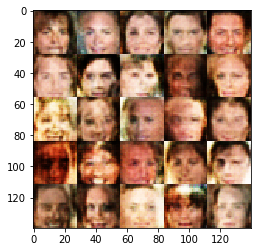

Epoch 2/3... Discriminator Loss: 1.2812... Generator Loss: 0.7331
Epoch 2/3... Discriminator Loss: 1.3660... Generator Loss: 0.7121
Epoch 2/3... Discriminator Loss: 1.1054... Generator Loss: 1.2360
Epoch 2/3... Discriminator Loss: 1.3236... Generator Loss: 0.9773
Epoch 2/3... Discriminator Loss: 1.2754... Generator Loss: 0.6906
Epoch 2/3... Discriminator Loss: 1.1706... Generator Loss: 0.8651
Epoch 2/3... Discriminator Loss: 1.2933... Generator Loss: 1.0683
Epoch 2/3... Discriminator Loss: 1.2029... Generator Loss: 1.0336
Epoch 2/3... Discriminator Loss: 1.3817... Generator Loss: 0.6434
Epoch 2/3... Discriminator Loss: 1.3573... Generator Loss: 0.6376


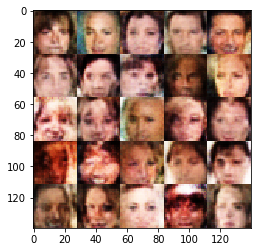

Epoch 2/3... Discriminator Loss: 1.2067... Generator Loss: 0.7722
Epoch 2/3... Discriminator Loss: 1.1680... Generator Loss: 0.7394
Epoch 2/3... Discriminator Loss: 1.2495... Generator Loss: 0.7135
Epoch 2/3... Discriminator Loss: 1.3385... Generator Loss: 0.7280
Epoch 2/3... Discriminator Loss: 1.1732... Generator Loss: 1.5310
Epoch 2/3... Discriminator Loss: 0.9753... Generator Loss: 1.0445
Epoch 2/3... Discriminator Loss: 1.1918... Generator Loss: 1.1645
Epoch 2/3... Discriminator Loss: 1.2576... Generator Loss: 1.2664
Epoch 2/3... Discriminator Loss: 1.1240... Generator Loss: 0.8691
Epoch 2/3... Discriminator Loss: 1.2247... Generator Loss: 1.0676


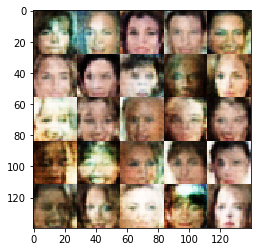

Epoch 2/3... Discriminator Loss: 1.2872... Generator Loss: 0.6853
Epoch 2/3... Discriminator Loss: 1.3049... Generator Loss: 0.6637
Epoch 2/3... Discriminator Loss: 1.2319... Generator Loss: 0.8676
Epoch 2/3... Discriminator Loss: 1.3761... Generator Loss: 0.5980
Epoch 2/3... Discriminator Loss: 1.5074... Generator Loss: 0.5817
Epoch 2/3... Discriminator Loss: 1.2985... Generator Loss: 0.6778
Epoch 2/3... Discriminator Loss: 1.4328... Generator Loss: 0.6081
Epoch 2/3... Discriminator Loss: 1.2570... Generator Loss: 1.0057
Epoch 2/3... Discriminator Loss: 1.2663... Generator Loss: 0.9854
Epoch 2/3... Discriminator Loss: 1.3194... Generator Loss: 0.6606


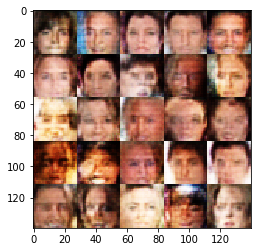

Epoch 2/3... Discriminator Loss: 1.3539... Generator Loss: 0.6558
Epoch 2/3... Discriminator Loss: 1.3694... Generator Loss: 0.6459
Epoch 2/3... Discriminator Loss: 1.2250... Generator Loss: 1.0214
Epoch 2/3... Discriminator Loss: 1.2779... Generator Loss: 0.8961
Epoch 2/3... Discriminator Loss: 1.0360... Generator Loss: 0.9856
Epoch 2/3... Discriminator Loss: 1.1963... Generator Loss: 0.9863
Epoch 2/3... Discriminator Loss: 1.1261... Generator Loss: 1.0375
Epoch 2/3... Discriminator Loss: 1.1639... Generator Loss: 1.0371
Epoch 2/3... Discriminator Loss: 1.2320... Generator Loss: 0.7203
Epoch 2/3... Discriminator Loss: 1.2091... Generator Loss: 0.8657


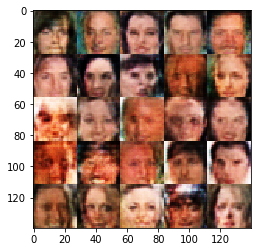

Epoch 2/3... Discriminator Loss: 1.3367... Generator Loss: 1.2000
Epoch 2/3... Discriminator Loss: 1.3344... Generator Loss: 1.0578
Epoch 2/3... Discriminator Loss: 1.1762... Generator Loss: 1.0313
Epoch 2/3... Discriminator Loss: 1.3208... Generator Loss: 0.6874
Epoch 2/3... Discriminator Loss: 0.9892... Generator Loss: 0.9188
Epoch 2/3... Discriminator Loss: 1.2901... Generator Loss: 0.6977
Epoch 2/3... Discriminator Loss: 1.1669... Generator Loss: 0.9393
Epoch 2/3... Discriminator Loss: 1.2779... Generator Loss: 0.6580
Epoch 2/3... Discriminator Loss: 1.2597... Generator Loss: 1.1886
Epoch 2/3... Discriminator Loss: 1.2974... Generator Loss: 0.6431


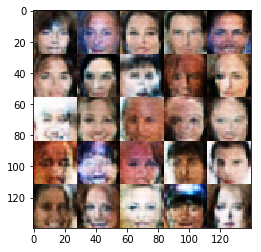

Epoch 2/3... Discriminator Loss: 1.2933... Generator Loss: 0.8771
Epoch 2/3... Discriminator Loss: 1.4115... Generator Loss: 0.6312
Epoch 2/3... Discriminator Loss: 1.3347... Generator Loss: 0.6960
Epoch 2/3... Discriminator Loss: 1.1324... Generator Loss: 0.7911
Epoch 2/3... Discriminator Loss: 1.5111... Generator Loss: 0.5377
Epoch 2/3... Discriminator Loss: 1.2675... Generator Loss: 1.3337
Epoch 2/3... Discriminator Loss: 1.1546... Generator Loss: 1.0225
Epoch 2/3... Discriminator Loss: 1.3901... Generator Loss: 0.6508
Epoch 2/3... Discriminator Loss: 1.1865... Generator Loss: 0.8422
Epoch 2/3... Discriminator Loss: 1.6236... Generator Loss: 0.4864


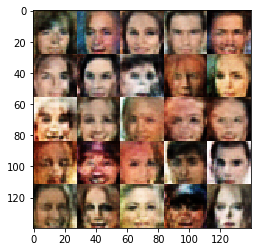

Epoch 2/3... Discriminator Loss: 1.1631... Generator Loss: 0.8452
Epoch 2/3... Discriminator Loss: 1.3258... Generator Loss: 0.6597
Epoch 2/3... Discriminator Loss: 1.1212... Generator Loss: 1.0494
Epoch 2/3... Discriminator Loss: 1.0153... Generator Loss: 1.5382
Epoch 2/3... Discriminator Loss: 1.0924... Generator Loss: 1.3753
Epoch 2/3... Discriminator Loss: 1.2524... Generator Loss: 1.2785
Epoch 2/3... Discriminator Loss: 1.2590... Generator Loss: 0.7725
Epoch 2/3... Discriminator Loss: 1.2020... Generator Loss: 0.9005
Epoch 2/3... Discriminator Loss: 1.0149... Generator Loss: 0.9924
Epoch 2/3... Discriminator Loss: 1.1905... Generator Loss: 1.1004


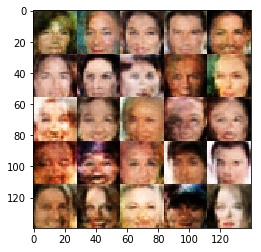

Epoch 2/3... Discriminator Loss: 1.1055... Generator Loss: 0.9976
Epoch 2/3... Discriminator Loss: 1.2751... Generator Loss: 1.2120
Epoch 2/3... Discriminator Loss: 1.2359... Generator Loss: 1.0296
Epoch 2/3... Discriminator Loss: 1.1796... Generator Loss: 1.0135
Epoch 2/3... Discriminator Loss: 1.2190... Generator Loss: 0.9679
Epoch 2/3... Discriminator Loss: 1.1273... Generator Loss: 0.8851
Epoch 2/3... Discriminator Loss: 0.9647... Generator Loss: 1.1996
Epoch 2/3... Discriminator Loss: 1.2827... Generator Loss: 0.7220
Epoch 2/3... Discriminator Loss: 1.4564... Generator Loss: 0.5351
Epoch 2/3... Discriminator Loss: 1.1322... Generator Loss: 1.0255


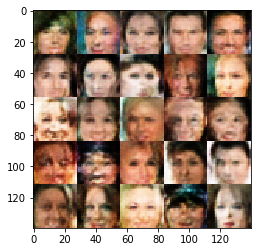

Epoch 2/3... Discriminator Loss: 1.3516... Generator Loss: 0.7062
Epoch 2/3... Discriminator Loss: 1.2993... Generator Loss: 0.6490
Epoch 2/3... Discriminator Loss: 1.1562... Generator Loss: 0.8280
Epoch 2/3... Discriminator Loss: 1.1904... Generator Loss: 0.9767
Epoch 2/3... Discriminator Loss: 1.0217... Generator Loss: 0.9513
Epoch 2/3... Discriminator Loss: 1.2668... Generator Loss: 0.6742
Epoch 2/3... Discriminator Loss: 1.5063... Generator Loss: 0.5196
Epoch 2/3... Discriminator Loss: 1.1649... Generator Loss: 1.0624
Epoch 2/3... Discriminator Loss: 0.9476... Generator Loss: 0.9987
Epoch 2/3... Discriminator Loss: 1.1673... Generator Loss: 0.8892


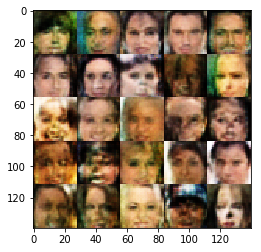

Epoch 2/3... Discriminator Loss: 1.1524... Generator Loss: 0.7704
Epoch 2/3... Discriminator Loss: 1.2168... Generator Loss: 0.9044
Epoch 2/3... Discriminator Loss: 1.4253... Generator Loss: 0.5558
Epoch 2/3... Discriminator Loss: 1.7040... Generator Loss: 0.4461
Epoch 2/3... Discriminator Loss: 1.1307... Generator Loss: 0.9128
Epoch 2/3... Discriminator Loss: 1.2597... Generator Loss: 0.7819
Epoch 2/3... Discriminator Loss: 1.2359... Generator Loss: 0.6927
Epoch 2/3... Discriminator Loss: 1.1685... Generator Loss: 0.9031
Epoch 2/3... Discriminator Loss: 1.0013... Generator Loss: 1.3114
Epoch 2/3... Discriminator Loss: 1.1272... Generator Loss: 1.2181


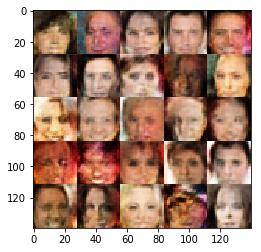

Epoch 2/3... Discriminator Loss: 1.1364... Generator Loss: 0.8250
Epoch 2/3... Discriminator Loss: 1.1533... Generator Loss: 0.8880
Epoch 2/3... Discriminator Loss: 1.2994... Generator Loss: 1.2377
Epoch 2/3... Discriminator Loss: 1.2103... Generator Loss: 1.1252
Epoch 2/3... Discriminator Loss: 1.2014... Generator Loss: 0.7069
Epoch 2/3... Discriminator Loss: 1.3550... Generator Loss: 0.6414
Epoch 2/3... Discriminator Loss: 1.3387... Generator Loss: 0.7854
Epoch 2/3... Discriminator Loss: 1.1528... Generator Loss: 0.9706
Epoch 2/3... Discriminator Loss: 1.5070... Generator Loss: 0.5659
Epoch 2/3... Discriminator Loss: 1.0325... Generator Loss: 1.0399


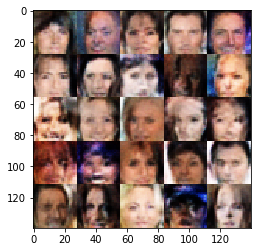

Epoch 2/3... Discriminator Loss: 1.2799... Generator Loss: 0.6929
Epoch 2/3... Discriminator Loss: 1.5290... Generator Loss: 0.8448
Epoch 2/3... Discriminator Loss: 1.2313... Generator Loss: 0.6933
Epoch 2/3... Discriminator Loss: 1.3947... Generator Loss: 0.6012
Epoch 2/3... Discriminator Loss: 1.1379... Generator Loss: 0.7766
Epoch 2/3... Discriminator Loss: 1.1285... Generator Loss: 1.1754
Epoch 2/3... Discriminator Loss: 1.2102... Generator Loss: 0.7398
Epoch 2/3... Discriminator Loss: 1.2028... Generator Loss: 1.0966
Epoch 2/3... Discriminator Loss: 0.9079... Generator Loss: 1.2619
Epoch 2/3... Discriminator Loss: 1.3586... Generator Loss: 0.6498


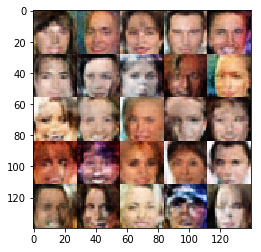

Epoch 2/3... Discriminator Loss: 1.1135... Generator Loss: 1.0083
Epoch 2/3... Discriminator Loss: 0.9806... Generator Loss: 1.1850
Epoch 2/3... Discriminator Loss: 1.0557... Generator Loss: 1.0990
Epoch 2/3... Discriminator Loss: 1.1297... Generator Loss: 1.1510
Epoch 2/3... Discriminator Loss: 1.0142... Generator Loss: 1.3125
Epoch 2/3... Discriminator Loss: 1.0622... Generator Loss: 0.8389
Epoch 2/3... Discriminator Loss: 1.2570... Generator Loss: 0.6798
Epoch 2/3... Discriminator Loss: 1.0871... Generator Loss: 0.9161
Epoch 2/3... Discriminator Loss: 1.1587... Generator Loss: 1.0167
Epoch 2/3... Discriminator Loss: 1.3537... Generator Loss: 0.6126


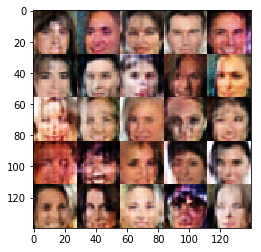

Epoch 2/3... Discriminator Loss: 1.3176... Generator Loss: 0.7864
Epoch 2/3... Discriminator Loss: 1.3418... Generator Loss: 0.6010
Epoch 2/3... Discriminator Loss: 0.9518... Generator Loss: 1.2885
Epoch 2/3... Discriminator Loss: 1.0521... Generator Loss: 0.9441
Epoch 2/3... Discriminator Loss: 1.0837... Generator Loss: 0.8669
Epoch 2/3... Discriminator Loss: 1.0850... Generator Loss: 0.8780
Epoch 2/3... Discriminator Loss: 1.2150... Generator Loss: 1.0858
Epoch 2/3... Discriminator Loss: 1.3890... Generator Loss: 0.6132
Epoch 2/3... Discriminator Loss: 1.4133... Generator Loss: 0.6035
Epoch 2/3... Discriminator Loss: 1.1710... Generator Loss: 0.8919


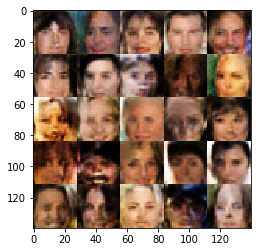

Epoch 2/3... Discriminator Loss: 1.4402... Generator Loss: 0.5491
Epoch 2/3... Discriminator Loss: 1.0553... Generator Loss: 0.9628
Epoch 2/3... Discriminator Loss: 1.1264... Generator Loss: 0.7674
Epoch 2/3... Discriminator Loss: 1.4674... Generator Loss: 0.5358
Epoch 2/3... Discriminator Loss: 1.0326... Generator Loss: 1.0956
Epoch 2/3... Discriminator Loss: 1.2009... Generator Loss: 1.0240
Epoch 2/3... Discriminator Loss: 1.2418... Generator Loss: 0.8095
Epoch 2/3... Discriminator Loss: 1.0683... Generator Loss: 0.9037
Epoch 2/3... Discriminator Loss: 1.3957... Generator Loss: 0.6307
Epoch 2/3... Discriminator Loss: 0.9783... Generator Loss: 0.9800


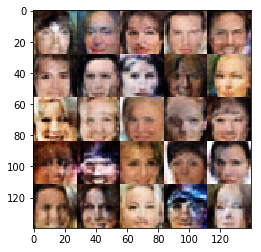

Epoch 2/3... Discriminator Loss: 1.2918... Generator Loss: 0.7391
Epoch 2/3... Discriminator Loss: 1.2796... Generator Loss: 1.4898
Epoch 2/3... Discriminator Loss: 1.0352... Generator Loss: 0.9527
Epoch 2/3... Discriminator Loss: 1.2093... Generator Loss: 0.8233
Epoch 2/3... Discriminator Loss: 0.9929... Generator Loss: 1.0922
Epoch 2/3... Discriminator Loss: 1.1668... Generator Loss: 1.0825
Epoch 3/3... Discriminator Loss: 1.3964... Generator Loss: 1.3816
Epoch 3/3... Discriminator Loss: 1.1282... Generator Loss: 1.0910
Epoch 3/3... Discriminator Loss: 1.3806... Generator Loss: 0.6433
Epoch 3/3... Discriminator Loss: 1.2370... Generator Loss: 0.7344


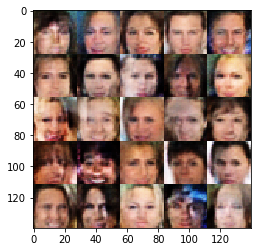

Epoch 3/3... Discriminator Loss: 1.0921... Generator Loss: 0.9471
Epoch 3/3... Discriminator Loss: 1.0768... Generator Loss: 0.9842
Epoch 3/3... Discriminator Loss: 1.1254... Generator Loss: 1.1580
Epoch 3/3... Discriminator Loss: 1.1494... Generator Loss: 1.6540
Epoch 3/3... Discriminator Loss: 1.1447... Generator Loss: 0.8068
Epoch 3/3... Discriminator Loss: 1.2994... Generator Loss: 0.6370
Epoch 3/3... Discriminator Loss: 1.1854... Generator Loss: 1.1034
Epoch 3/3... Discriminator Loss: 1.1956... Generator Loss: 0.6973
Epoch 3/3... Discriminator Loss: 1.0157... Generator Loss: 1.0723
Epoch 3/3... Discriminator Loss: 1.2404... Generator Loss: 0.7043


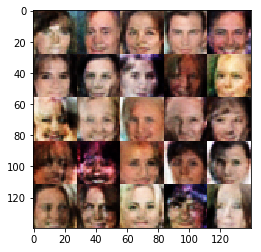

Epoch 3/3... Discriminator Loss: 1.1642... Generator Loss: 0.9093
Epoch 3/3... Discriminator Loss: 1.1318... Generator Loss: 0.8955
Epoch 3/3... Discriminator Loss: 1.1665... Generator Loss: 1.2547
Epoch 3/3... Discriminator Loss: 1.2962... Generator Loss: 0.8425
Epoch 3/3... Discriminator Loss: 1.0037... Generator Loss: 1.3292
Epoch 3/3... Discriminator Loss: 1.3986... Generator Loss: 0.5745
Epoch 3/3... Discriminator Loss: 1.1812... Generator Loss: 0.9557
Epoch 3/3... Discriminator Loss: 1.2668... Generator Loss: 1.1399
Epoch 3/3... Discriminator Loss: 1.0604... Generator Loss: 1.3857
Epoch 3/3... Discriminator Loss: 1.3840... Generator Loss: 0.6125


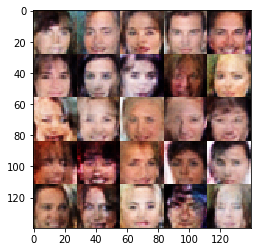

Epoch 3/3... Discriminator Loss: 1.3357... Generator Loss: 1.9478
Epoch 3/3... Discriminator Loss: 1.3391... Generator Loss: 0.7154
Epoch 3/3... Discriminator Loss: 1.1565... Generator Loss: 1.0268
Epoch 3/3... Discriminator Loss: 1.2487... Generator Loss: 0.6470
Epoch 3/3... Discriminator Loss: 1.2076... Generator Loss: 0.8046
Epoch 3/3... Discriminator Loss: 1.0502... Generator Loss: 1.3803
Epoch 3/3... Discriminator Loss: 1.1797... Generator Loss: 0.9782
Epoch 3/3... Discriminator Loss: 1.4069... Generator Loss: 1.7514
Epoch 3/3... Discriminator Loss: 1.1566... Generator Loss: 1.1291
Epoch 3/3... Discriminator Loss: 1.1946... Generator Loss: 0.7067


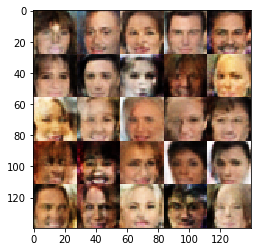

Epoch 3/3... Discriminator Loss: 1.1568... Generator Loss: 1.7551
Epoch 3/3... Discriminator Loss: 1.0725... Generator Loss: 1.0003
Epoch 3/3... Discriminator Loss: 1.4080... Generator Loss: 0.5300
Epoch 3/3... Discriminator Loss: 1.0140... Generator Loss: 1.0485
Epoch 3/3... Discriminator Loss: 1.3512... Generator Loss: 0.6333
Epoch 3/3... Discriminator Loss: 1.2674... Generator Loss: 0.7251
Epoch 3/3... Discriminator Loss: 1.0359... Generator Loss: 0.9478
Epoch 3/3... Discriminator Loss: 1.1995... Generator Loss: 0.8219
Epoch 3/3... Discriminator Loss: 1.1952... Generator Loss: 0.6689
Epoch 3/3... Discriminator Loss: 0.9521... Generator Loss: 1.0427


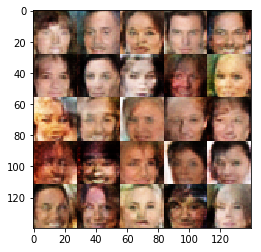

Epoch 3/3... Discriminator Loss: 1.2535... Generator Loss: 0.7002
Epoch 3/3... Discriminator Loss: 1.2148... Generator Loss: 1.1620
Epoch 3/3... Discriminator Loss: 1.1297... Generator Loss: 1.0796
Epoch 3/3... Discriminator Loss: 1.1691... Generator Loss: 0.8781
Epoch 3/3... Discriminator Loss: 1.3737... Generator Loss: 1.4677
Epoch 3/3... Discriminator Loss: 1.2274... Generator Loss: 0.6894
Epoch 3/3... Discriminator Loss: 1.2219... Generator Loss: 0.7174
Epoch 3/3... Discriminator Loss: 1.1682... Generator Loss: 0.8035
Epoch 3/3... Discriminator Loss: 1.1650... Generator Loss: 0.7846
Epoch 3/3... Discriminator Loss: 1.1693... Generator Loss: 0.9005


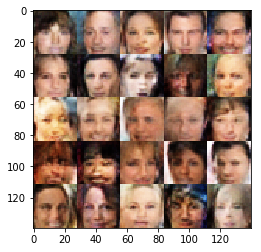

Epoch 3/3... Discriminator Loss: 1.4199... Generator Loss: 0.5443
Epoch 3/3... Discriminator Loss: 1.1794... Generator Loss: 0.8209
Epoch 3/3... Discriminator Loss: 1.1517... Generator Loss: 0.7970
Epoch 3/3... Discriminator Loss: 1.0126... Generator Loss: 1.0389
Epoch 3/3... Discriminator Loss: 1.1337... Generator Loss: 1.1461
Epoch 3/3... Discriminator Loss: 1.0842... Generator Loss: 1.0235
Epoch 3/3... Discriminator Loss: 1.2207... Generator Loss: 0.6545
Epoch 3/3... Discriminator Loss: 1.2922... Generator Loss: 1.1742
Epoch 3/3... Discriminator Loss: 1.2096... Generator Loss: 0.7673
Epoch 3/3... Discriminator Loss: 1.4161... Generator Loss: 1.1888


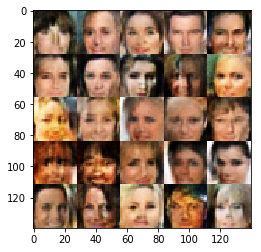

Epoch 3/3... Discriminator Loss: 1.2136... Generator Loss: 0.8196
Epoch 3/3... Discriminator Loss: 1.1426... Generator Loss: 0.9811
Epoch 3/3... Discriminator Loss: 1.1664... Generator Loss: 0.9450
Epoch 3/3... Discriminator Loss: 1.2522... Generator Loss: 0.7283
Epoch 3/3... Discriminator Loss: 1.0117... Generator Loss: 1.4267
Epoch 3/3... Discriminator Loss: 1.0854... Generator Loss: 0.9558
Epoch 3/3... Discriminator Loss: 1.1607... Generator Loss: 0.7941
Epoch 3/3... Discriminator Loss: 1.1912... Generator Loss: 0.7143
Epoch 3/3... Discriminator Loss: 0.8525... Generator Loss: 1.6310
Epoch 3/3... Discriminator Loss: 1.1836... Generator Loss: 0.9374


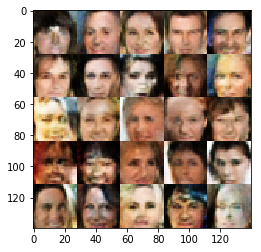

Epoch 3/3... Discriminator Loss: 0.9583... Generator Loss: 1.1785
Epoch 3/3... Discriminator Loss: 1.2572... Generator Loss: 0.6690
Epoch 3/3... Discriminator Loss: 1.0281... Generator Loss: 1.1159
Epoch 3/3... Discriminator Loss: 1.2492... Generator Loss: 1.0937
Epoch 3/3... Discriminator Loss: 0.9702... Generator Loss: 0.9995
Epoch 3/3... Discriminator Loss: 1.2286... Generator Loss: 0.7222
Epoch 3/3... Discriminator Loss: 1.1489... Generator Loss: 0.9297
Epoch 3/3... Discriminator Loss: 1.1342... Generator Loss: 1.2724
Epoch 3/3... Discriminator Loss: 1.1917... Generator Loss: 0.8178
Epoch 3/3... Discriminator Loss: 1.2236... Generator Loss: 0.7221


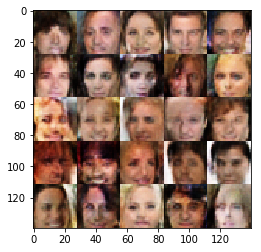

Epoch 3/3... Discriminator Loss: 1.3170... Generator Loss: 0.8853
Epoch 3/3... Discriminator Loss: 1.2541... Generator Loss: 1.0569
Epoch 3/3... Discriminator Loss: 1.4496... Generator Loss: 0.6239
Epoch 3/3... Discriminator Loss: 1.3922... Generator Loss: 0.5834
Epoch 3/3... Discriminator Loss: 1.2114... Generator Loss: 0.6537
Epoch 3/3... Discriminator Loss: 1.3092... Generator Loss: 1.1026
Epoch 3/3... Discriminator Loss: 1.1002... Generator Loss: 1.0116
Epoch 3/3... Discriminator Loss: 1.3328... Generator Loss: 0.6434
Epoch 3/3... Discriminator Loss: 1.0555... Generator Loss: 1.1362
Epoch 3/3... Discriminator Loss: 1.1998... Generator Loss: 0.9791


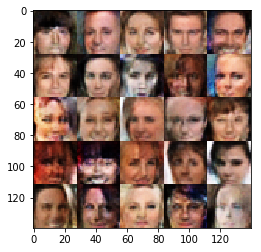

Epoch 3/3... Discriminator Loss: 1.0005... Generator Loss: 1.0416
Epoch 3/3... Discriminator Loss: 1.5006... Generator Loss: 0.4938
Epoch 3/3... Discriminator Loss: 1.0659... Generator Loss: 0.8833
Epoch 3/3... Discriminator Loss: 1.1403... Generator Loss: 0.9908
Epoch 3/3... Discriminator Loss: 1.0955... Generator Loss: 0.9292
Epoch 3/3... Discriminator Loss: 1.1504... Generator Loss: 0.8500
Epoch 3/3... Discriminator Loss: 1.0654... Generator Loss: 1.2436
Epoch 3/3... Discriminator Loss: 1.0618... Generator Loss: 0.9146
Epoch 3/3... Discriminator Loss: 1.1907... Generator Loss: 0.8047
Epoch 3/3... Discriminator Loss: 1.2926... Generator Loss: 0.6749


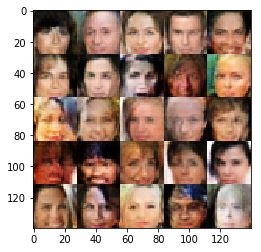

Epoch 3/3... Discriminator Loss: 1.0473... Generator Loss: 1.1974
Epoch 3/3... Discriminator Loss: 1.1431... Generator Loss: 0.7541
Epoch 3/3... Discriminator Loss: 1.0680... Generator Loss: 1.1427
Epoch 3/3... Discriminator Loss: 1.3774... Generator Loss: 0.5751
Epoch 3/3... Discriminator Loss: 1.0888... Generator Loss: 0.8234
Epoch 3/3... Discriminator Loss: 1.1091... Generator Loss: 0.9635
Epoch 3/3... Discriminator Loss: 1.4558... Generator Loss: 0.5289
Epoch 3/3... Discriminator Loss: 1.1030... Generator Loss: 0.8984
Epoch 3/3... Discriminator Loss: 1.1737... Generator Loss: 1.0109
Epoch 3/3... Discriminator Loss: 1.2326... Generator Loss: 0.6760


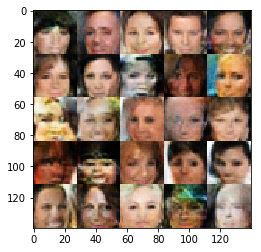

Epoch 3/3... Discriminator Loss: 1.1567... Generator Loss: 1.3725
Epoch 3/3... Discriminator Loss: 1.1038... Generator Loss: 1.2004
Epoch 3/3... Discriminator Loss: 1.2185... Generator Loss: 0.7047
Epoch 3/3... Discriminator Loss: 1.1432... Generator Loss: 1.0437
Epoch 3/3... Discriminator Loss: 1.2484... Generator Loss: 1.6265
Epoch 3/3... Discriminator Loss: 1.0111... Generator Loss: 1.4896
Epoch 3/3... Discriminator Loss: 1.5415... Generator Loss: 0.4910
Epoch 3/3... Discriminator Loss: 1.0916... Generator Loss: 1.1390
Epoch 3/3... Discriminator Loss: 1.2693... Generator Loss: 0.9753
Epoch 3/3... Discriminator Loss: 1.0978... Generator Loss: 1.0806


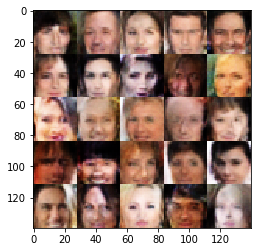

Epoch 3/3... Discriminator Loss: 1.1372... Generator Loss: 0.9311
Epoch 3/3... Discriminator Loss: 1.1212... Generator Loss: 0.8492
Epoch 3/3... Discriminator Loss: 1.4809... Generator Loss: 0.5097
Epoch 3/3... Discriminator Loss: 1.1032... Generator Loss: 1.0864
Epoch 3/3... Discriminator Loss: 1.2218... Generator Loss: 1.2135
Epoch 3/3... Discriminator Loss: 1.0202... Generator Loss: 0.9064
Epoch 3/3... Discriminator Loss: 0.9230... Generator Loss: 1.6656
Epoch 3/3... Discriminator Loss: 1.1861... Generator Loss: 0.7832
Epoch 3/3... Discriminator Loss: 1.2105... Generator Loss: 0.8074
Epoch 3/3... Discriminator Loss: 1.3649... Generator Loss: 1.3071


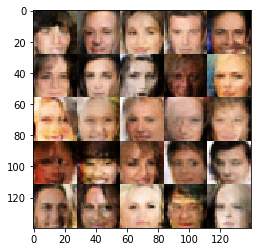

Epoch 3/3... Discriminator Loss: 1.4157... Generator Loss: 1.0221
Epoch 3/3... Discriminator Loss: 1.1561... Generator Loss: 0.8463
Epoch 3/3... Discriminator Loss: 1.1426... Generator Loss: 1.4267
Epoch 3/3... Discriminator Loss: 1.3250... Generator Loss: 0.7545
Epoch 3/3... Discriminator Loss: 0.9666... Generator Loss: 1.4217
Epoch 3/3... Discriminator Loss: 1.1707... Generator Loss: 0.8145
Epoch 3/3... Discriminator Loss: 1.3052... Generator Loss: 0.7833
Epoch 3/3... Discriminator Loss: 1.1674... Generator Loss: 0.8376
Epoch 3/3... Discriminator Loss: 1.0144... Generator Loss: 1.0395
Epoch 3/3... Discriminator Loss: 1.2589... Generator Loss: 0.6139


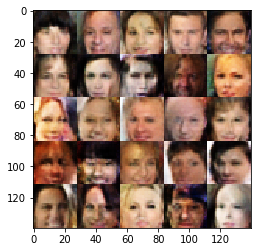

Epoch 3/3... Discriminator Loss: 1.2786... Generator Loss: 0.6376
Epoch 3/3... Discriminator Loss: 1.1021... Generator Loss: 1.1840
Epoch 3/3... Discriminator Loss: 1.6367... Generator Loss: 0.5167
Epoch 3/3... Discriminator Loss: 1.0657... Generator Loss: 0.9117
Epoch 3/3... Discriminator Loss: 1.1176... Generator Loss: 1.3436
Epoch 3/3... Discriminator Loss: 1.2272... Generator Loss: 0.9780
Epoch 3/3... Discriminator Loss: 1.2725... Generator Loss: 0.6336
Epoch 3/3... Discriminator Loss: 1.2019... Generator Loss: 0.6544
Epoch 3/3... Discriminator Loss: 1.2052... Generator Loss: 0.9552
Epoch 3/3... Discriminator Loss: 1.0407... Generator Loss: 1.0544


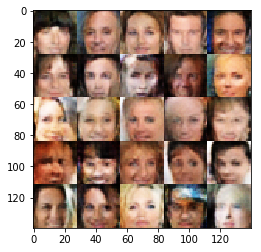

Epoch 3/3... Discriminator Loss: 1.0254... Generator Loss: 0.9340
Epoch 3/3... Discriminator Loss: 1.1217... Generator Loss: 1.0045
Epoch 3/3... Discriminator Loss: 1.1448... Generator Loss: 0.8026
Epoch 3/3... Discriminator Loss: 1.3136... Generator Loss: 0.8194


In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.